## Skeletal descriptors

In [4]:
import networkx as nx
import numpy as np
from itertools import product
import numpy.ma as ma
from toolz.curried import pipe, curry
from toolz.curried import map as fmap
import zipfile
import pandas as pd
import time
from skimage.morphology import medial_axis, skeletonize
import sknw
import matplotlib.pyplot as plt

In [19]:
zip_stream = zipfile.ZipFile('../data/cahn-hilliard.zip', 'r')

def read_data(file_name):
    return np.array(
        pd.read_csv(
            zip_stream.open(file_name, 'r'),
            delimiter=' ',
            header=None               
        ).swapaxes(0, 1)
    )

data = np.array(
    list(
        map(read_data, zip_stream.namelist()[1:])
    )
)

In [80]:
def neighborhood(nx, ny):
    vertex_list = np.array(range(nx * ny))
    # neighborhood = np.zeros([vertex_list.shape[0], 8])

    return neighborhood


def skeletonize(morph):
    skel, distance = medial_axis(morph, return_distance=True)
    return skel, distance


def skeletal_len(skeleton):
    return np.count_nonzero(skeleton)


def f_skeletal_pixels(skeleton):
    count = np.count_nonzero(skeleton)
    return round(count / skeleton.size, 2)


def getSkeletalGraph(skeleton):
    graph = sknw.build_sknw(skeleton)
    return graph


def getEndJunction(graph):
    l = [graph.degree[n] for n in graph.nodes()]
    return np.array([l.count(1), l.count(3)])


def getBranchLen(graph):
    b_l = [graph.edges[e]["weight"] for e in graph.edges()]
    return np.array([len(b_l), round(sum(b_l) / len(b_l), 2)])


def number_of_cycles(graph):
    cycles = 0
    for cc in sorted(nx.connected_components(graph), key=len, reverse=True):
        if len(cc) > 2:
            sgraph = graph.subgraph(cc)
            cycles += max((sgraph.number_of_edges() - sgraph.number_of_nodes()) + 1, 0)
    return cycles


def getSkeletalDescriptors(data):

    [skeleton_a, distance_map_a] = skeletonize(data)
    [skeleton_b, distance_map_b] = skeletonize(1 - data)

    graph_a = getSkeletalGraph(skeleton_a)
    graph_b = getSkeletalGraph(skeleton_b)

    [e_a, j_a] = getEndJunction(graph_a)
    [bn_a, bl_a] = getBranchLen(graph_a)
    [e_b, j_b] = getEndJunction(graph_b)
    [bn_b, bl_b] = getBranchLen(graph_b)

    dist_on_skel_a = distance_map_a * skeleton_a
    d_a = dist_on_skel_a[skeleton_a]
    dist_on_skel_b = distance_map_b * skeleton_b
    d_b = dist_on_skel_b[skeleton_b]

    
    return dict(
        f_skeletal_pixels_a=f_skeletal_pixels(skeleton_a),
        f_skeletal_pixels_b=f_skeletal_pixels(skeleton_b),
        number_of_ends_a=e_a,
        number_of_ends_b=e_b,
        number_of_intersections_a=j_a,
        number_of_intersections_b=j_b,
        number_of_branches_a=bn_a,
        number_of_branches_b=bn_b,
        branch_length_a=bl_a,
        branch_length_b=bl_b,
        dist_to_interface_min_a=min(d_a),
        dist_to_interface_min_b=min(d_b),
        dist_to_interface_max_a=max(d_a),
        dist_to_interface_max_b=max(d_b),
        dist_to_interface_avg_a=round(sum(d_a) / len(d_a), 2),
        dist_to_interface_avg_b=round(sum(d_b) / len(d_b), 2),
        number_of_cycles_a = number_of_cycles(graph_a),
        number_of_cycles_b = number_of_cycles(graph_b),
    )


In [81]:
A = data[370, :, :]
[skeleton_a, distance_map_a] = skeletonize(A)

In [82]:
g = getSkeletalGraph(skeleton_a)


In [83]:
getSkeletalDescriptors(A)

{'f_skeletal_pixels_a': 0.04,
 'f_skeletal_pixels_b': 0.02,
 'number_of_ends_a': 21,
 'number_of_ends_b': 52,
 'number_of_intersections_a': 27,
 'number_of_intersections_b': 6,
 'number_of_branches_a': 54.0,
 'number_of_branches_b': 36.0,
 'branch_length_a': 32.84,
 'branch_length_b': 27.7,
 'dist_to_interface_min_a': 1.0,
 'dist_to_interface_min_b': 1.0,
 'dist_to_interface_max_a': 13.0,
 'dist_to_interface_max_b': 13.0,
 'dist_to_interface_avg_a': 7.42,
 'dist_to_interface_avg_b': 7.43,
 'number_of_cycles_a': 6,
 'number_of_cycles_b': 0}

In [27]:
g.number_of_nodes()

26

In [71]:
cycles = 0
for c in sorted(nx.connected_components(g), key=len, reverse=True):
    if len(c) > 2:
        print(c)
        g2 = g.subgraph(c)
        cycles += max((g2.number_of_edges() - g2.number_of_nodes()) + 1, 0)
    print("\n\n")
print(cycles)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49}









6


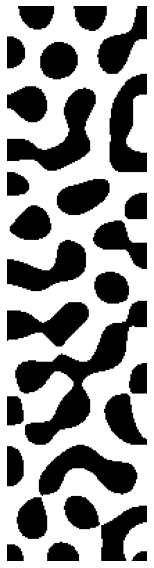

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True)


ax.imshow(A, cmap=plt.cm.gray)
ax.axis('off')


fig.tight_layout()

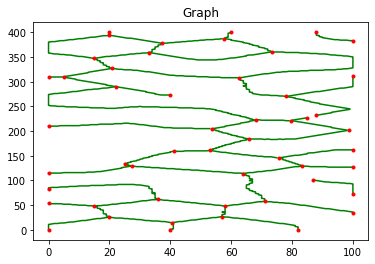

<Figure size 432x288 with 0 Axes>

In [70]:
for (s,e) in g.edges():
    ps = g[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')

# Plot nodes of the network    
nodes = g.nodes()
ps = np.array([nodes[l]['o'] for l in g.nodes()])
plt.plot(ps[:,1], ps[:,0], 'r.')

plt.title('Graph')
plt.show()
plt.tight_layout()

